### Imports

In [1]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

### Load data
Loading in the result of converting Agilent .d to mzML to a parsed HDF5 file. The HDF5 file stores the data in a format `deimos` uses internally: a `pandas` dataframe with separation coordinates (e.g. _m/z_, drift time, retention time) and abundance/intensity. This improves read/write times and organizes the data in a more useful way than mzML (mzML organizes based on how the data is acquired, whereas we organize based on how we will actually use the data).

```python
# example code for loading from mzML and saving to HDF5
# the following will not run in this tutorial
data = deimos.read_mzml('data/input.mzML.gz', accession={'drift_time': 'MS:1002476',
                                                         'retention_time': 'MS:1000016'})
deimos.save_hdf('data/output.h5', data['ms1'], key='ms1', mode='w')
deimos.save_hdf('data/output.h5', data['ms2'], key='ms2', mode='a')
```

In [2]:
# initialize dictionary
ms1 = {}
ms2 = {}

# load ms1 data
ms1['a'] = deimos.load_hdf('data/a_POS_40V.h5', key='ms1')
ms1['b'] = deimos.load_hdf('data/b_POS_40V.h5', key='ms1')

# load ms2 data
ms2['a'] = deimos.load_hdf('data/a_POS_40V.h5', key='ms2')
ms2['b'] = deimos.load_hdf('data/b_POS_40V.h5', key='ms2')

In [3]:
# look at one of the datasets
ms1['a'].head()

,drift_time,intensity,mz,retention_time
0,0.0,0.0,56.695583,0.085517
1,0.0,2.0,56.698189,0.085517
2,0.0,0.0,56.700794,0.085517
3,0.0,0.0,77.520805,0.085517
4,0.0,3.0,77.523857,0.085517


### Peak detection
As peakpicking is a fairly memory- and time- intensive task, we will skip it in this case, in favor of simply providing the peakpicked results.

```python
# example peakpicking code
# the following will not run in this tutorial

# initialize ms1 peak container
ms1_peaks = {}

# iterate over ms1 datasets
for k in ms1.keys():
    # partition data into chunks to limit memory usage
    # more on partitioning/mapping later in this notebook
    partitions = deimos.partition(ms1[k],
                                  split_on='mz',
                                  size=500,
                                  overlap=0.05)

    # map peakpicking algorithm to each partition
    # note that more configuration parameters are available
    ms1_peaks[k] = partitions.map(deimos.peakpick.local_maxima,
                                  dims=['mz', 'drift_time', 'retention_time'],
                                  processes=4)

    # save result
    deimos.save_hdf('peaks/{}_POS_40V.h5'.format(k), ms1_peaks[k], key='ms1', mode='w')
```

In [4]:
# initialize dictionary
ms1_peaks = {}

# load ms1 data
ms1_peaks['a'] = deimos.load_hdf('peaks/a_POS_40V.h5', key='ms1')
ms1_peaks['b'] = deimos.load_hdf('peaks/b_POS_40V.h5', key='ms1')

In [5]:
# look at one of the peakpicked datasets
ms1_peaks['a'].head()

,drift_time,intensity,mz,nonzero_2,nonzero_4,npoints_2,npoints_4,retention_time,sigma_drift_time_2,sigma_drift_time_4,sigma_mz_2,sigma_mz_4,sigma_retention_time_2,sigma_retention_time_4,sum_2,sum_4
0,0.000000,9.0,49.966354,1.0,1.0,2.0,2.0,6.848417,2.0,4.0,5.0,11.0,7.0,15.0,8.999999,9.000000
1,0.480992,4.0,49.966354,1.0,6.0,2.0,14.0,1.708733,2.0,4.0,5.0,11.0,7.0,15.0,4.000000,11.000001
2,1.322728,5.0,49.966354,1.0,3.0,3.0,8.0,2.327050,2.0,4.0,5.0,11.0,7.0,15.0,5.000000,9.000000
3,1.803720,19.0,49.966354,4.0,7.0,5.0,12.0,2.249700,2.0,4.0,5.0,11.0,7.0,15.0,41.999996,51.000000
4,1.923968,3.0,49.966354,2.0,3.0,3.0,6.0,4.645800,2.0,4.0,5.0,11.0,7.0,15.0,5.000000,8.000000


There are a lot of additional columns here. For now, just ignore this and recognize that we have peak coordinates (mz, drift_time, retention_time) and peak apex abundance (intensity).

### Threshold features
For some operations, it's important to reduce the number of data points in the interest of algorithmic efficiency. Below, we will threshold our datasets with a cutoff of 300 (arbitrary). Additional ways to threshold would be through the other peak metadata (those "extra" columns mentioned when we loaded in the peak data).

In [6]:
# threshold by intensity
ms1_peaks['a_thresh_i'] = deimos.threshold(ms1_peaks['a'], threshold=300)
ms1_peaks['b_thresh_i'] = deimos.threshold(ms1_peaks['b'], threshold=300)

print('Before:\t{}'.format(len(ms1_peaks['a'].index)))
print('After:\t{}'.format(len(ms1_peaks['a_thresh_i'].index)))

Before:	7510578
After:	10477


### Collapsing (summing) data
There are several key functions that will help with your analysis. First up, `deimos.collapse`. This function collapses any dimensions not specified in `keep` according to the function supplied in `how`. For example, if we want to sum across drift time and retention time, keeping only the _m/z_ distribution:

In [8]:
# collapse
ms1_mz_only = deimos.collapse(ms1['a'], keep='mz', how=np.sum)
print('Before:\t{}'.format(ms1['a'].values.shape))
print('After:\t{}'.format(ms1_mz_only.values.shape))

Before:	(137796027, 4)
After:	(197408, 2)


We went from 4 columns with ~137 million unique coordinates, to just two columns (_m/z_ and intensity) with ~200 thousand unique coordinates. 

### Subset data

Next we'll look at subsetting functions, `deimos.locate` and `deimos.slice`. The former returns a subset of the data centered at some coordinate (defined by `loc`) within provided tolerances in each dimension (defined by `tol`). So, given the coordinate of a peak, we can subset the raw data in that region to plot:

In [9]:
# grab an arbitrary peak
# high intensity to make our lives easier
peak = ms1_peaks['a_thresh_i'].sort_values(by='intensity', ascending=False).reset_index(drop=True).iloc[0, :]
peak = peak[['mz', 'drift_time', 'retention_time', 'intensity']]
peak

mz                  144.099228
drift_time           14.670256
retention_time        7.311867
intensity         59661.000000
Name: 0, dtype: float32

/Users/colb804/repos/deimos/deimos/plot.py:126: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/opt/anaconda3/envs/deimos_base/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



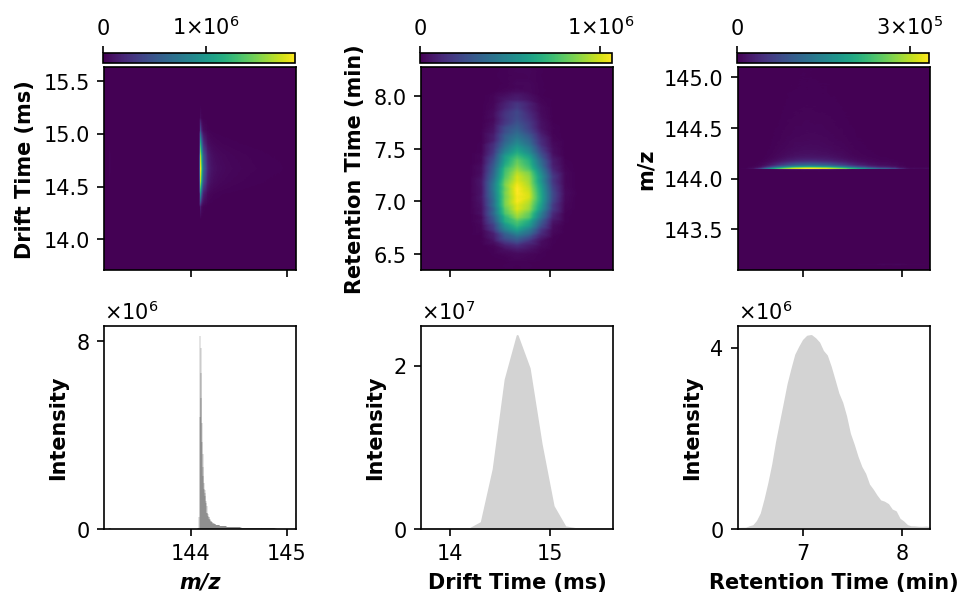

In [10]:
# subset the data
subset = deimos.locate(ms1['a'],
                       by=['mz', 'drift_time', 'retention_time'],
                       loc=peak[['mz', 'drift_time', 'retention_time']],
                       tol=[1, 1, 1])

# plot
deimos.plot.multipanel(subset, dpi=150, grid_kwargs={'cmap': 'viridis'})
plt.tight_layout()
plt.show()

We can achieve the same using the `slice` function, which instead of `loc` and `tol` takes bounds `low` and `high`. This allows us to zoom in on the isotopic signature to the right of our peak (as opposed to a symetrical window).

/Users/colb804/repos/deimos/deimos/plot.py:126: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/opt/anaconda3/envs/deimos_base/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



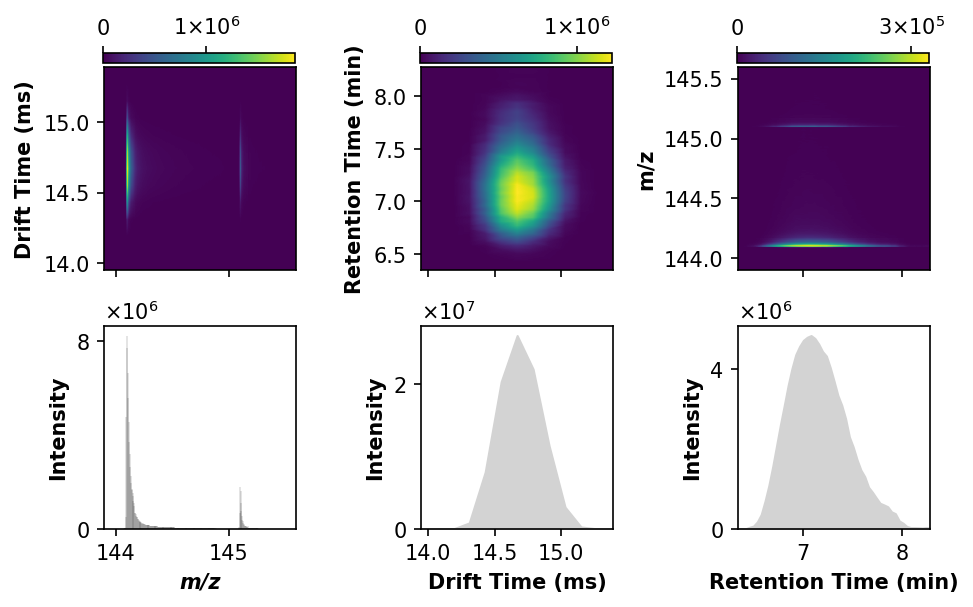

In [11]:
# subset the data
subset = deimos.slice(ms1['a'],
                      by=['mz', 'drift_time', 'retention_time'],
                      low=peak[['mz', 'drift_time', 'retention_time']] - [0.2, 0.8, 1.0],
                      high=peak[['mz', 'drift_time', 'retention_time']] + [1.5, 0.8, 1.0])

# plot
deimos.plot.multipanel(subset, dpi=150, grid_kwargs={'cmap': 'viridis'})
plt.tight_layout()
plt.show()

Similarly, we can use `locate` or `slice` to pull MS2 in a corresponding window. This is acheived through non-_m/z_ separation dimensions (in LC-IMS-MS, retention time and drift time). Using the above MS1 feature as an example, this would just mean dropping the _m/z_ terms from the call to `slice`.

/Users/colb804/repos/deimos/deimos/plot.py:126: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/opt/anaconda3/envs/deimos_base/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



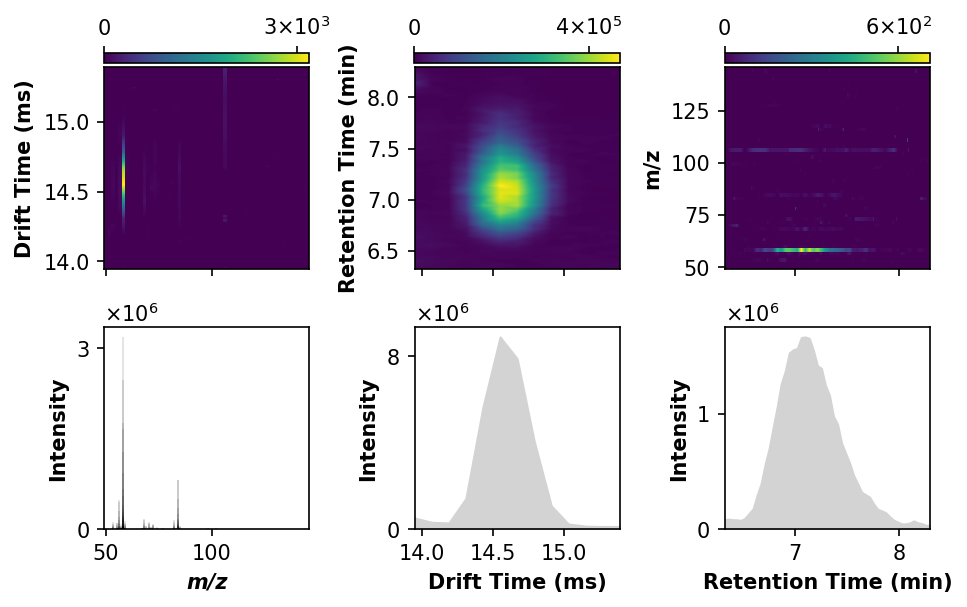

In [12]:
# subset the ms2 data
ms2_subset = deimos.slice(ms2['a'],
                          by=['drift_time', 'retention_time'],
                          low=peak[['drift_time', 'retention_time']] - [0.8, 1.0],
                          high=peak[['drift_time', 'retention_time']] + [0.8, 1.0])

# plot
ax = deimos.plot.multipanel(ms2_subset, dpi=150, grid_kwargs={'cmap': 'viridis'})

# set xlim to only include fragments equal to or lower than the MS1 parent m/z
ax['mz'].set_xlim(None, 146)

plt.tight_layout()
plt.show()

You can see that the drift and retention time panels look fairly similar to the MS1, however, notice that the drift times are actually shifted slightly left. This is due to properties of the instrument. Our isolation window is wide enough such that this is not an issue, but when performing deconvolution, drift times must be shifted to accommodate. Also, because we're considering all possible _m/z_ in this view, the panels involving _m/z_ are not particularly useful. Instead, we usually plot the _m/z_ from MS2 spectra in their own panel using `deimos.plot.stem`:

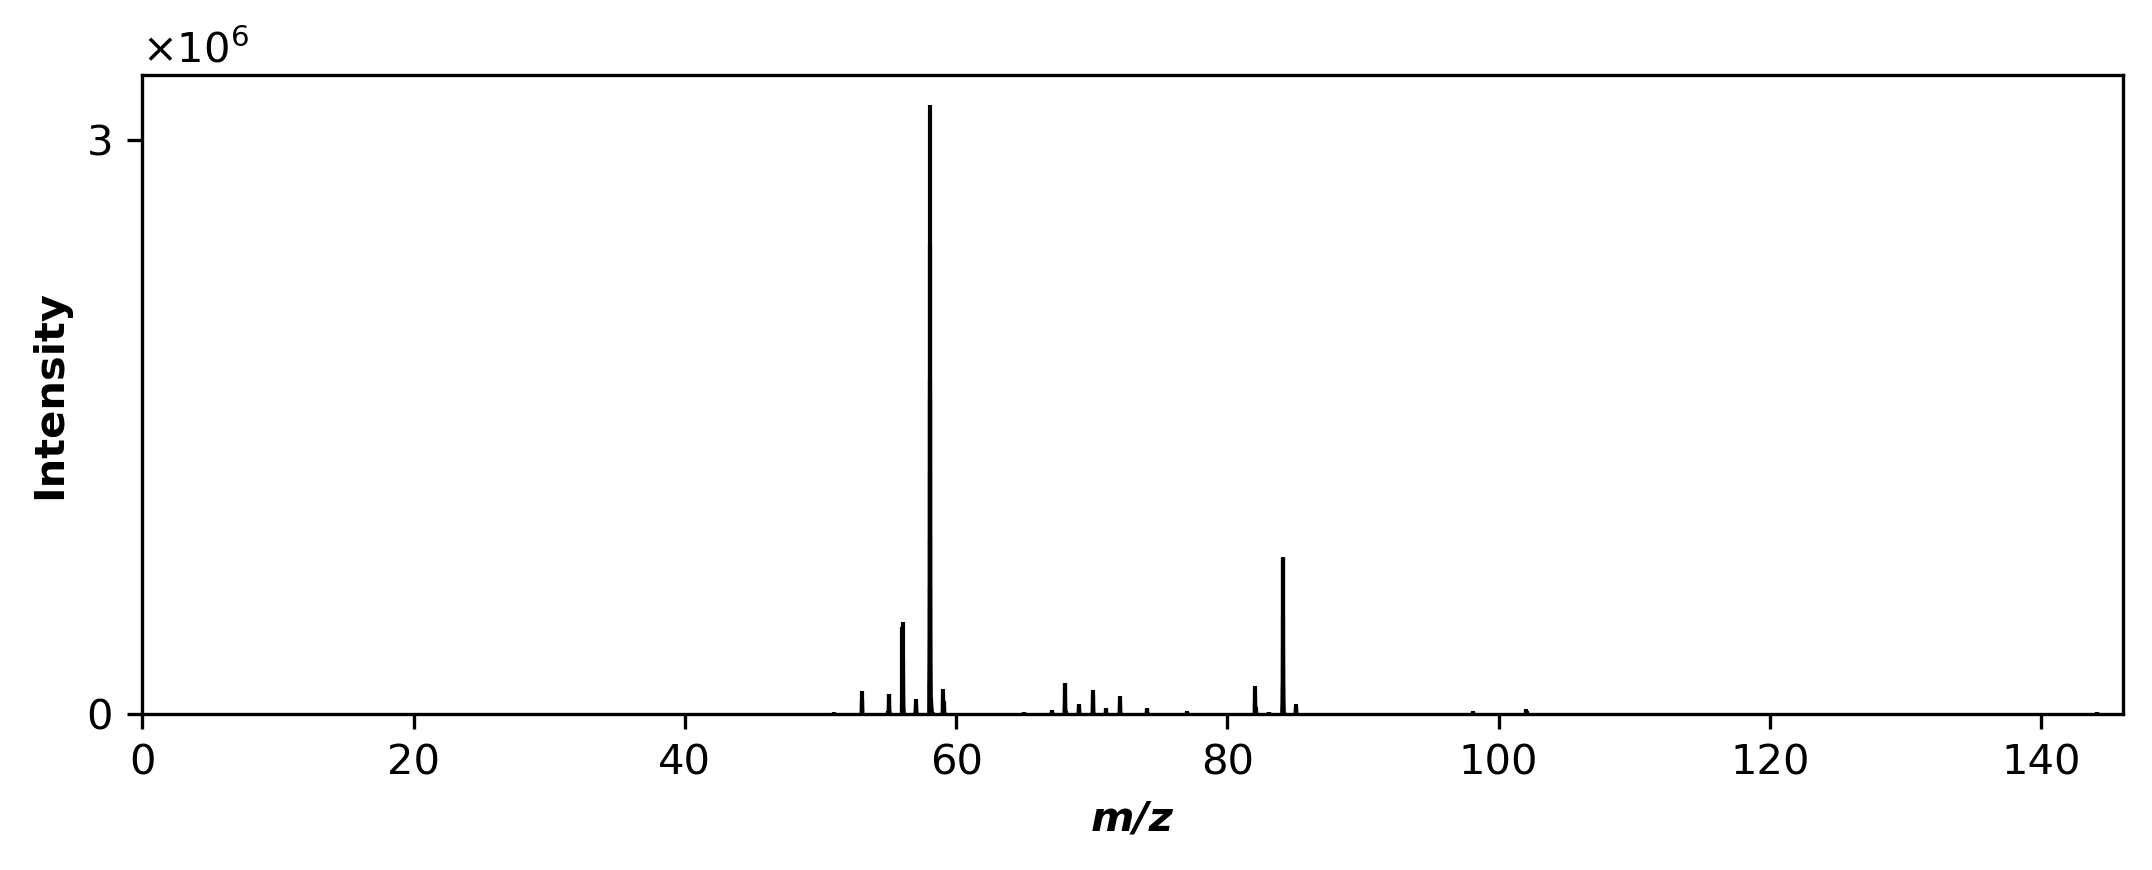

In [13]:
# first, collapse to keep only m/z
ms2_mz_only = deimos.collapse(ms2_subset, keep='mz')

# plot
fig, ax = plt.subplots(1, dpi=300, figsize=(1.5 * 4.85, 3))
deimos.plot.stem(ms2_mz_only['mz'], ms2_mz_only['intensity'], width=1, ax=ax)

# again, only care about fragments less than or equal to the parent m/z
plt.xlim(0, 146)

plt.tight_layout()
plt.show()

Keep in mind, there could be multiple parent MS1 features that share these windows in drift and retention time for MS2 extraction, such that their fragmentation patterns would be mixed. This is why deconvolution is important. However, in the case of just visually and interactively inspecting the data, selecting a region in MS1, then using the accompanying drift and retention times to show MS2 fragments, is totally fine.

### Match features
Next we are going to match features between two datasets. This will return two dataframes, where row indices are matched up (i.e., entry _i_ in `a_match` corresponds to entry _i_ in `b_match`). Note that we can do this two ways: with `deimos.alignment.match` directy, or by using `deimos.partition`, which will partition the data in the _m/z_ dimension and process each partition separately (optionally using multiple processes (here, `processes=4`).

In [14]:
# match features using NxM distances
start = time.time()
a_match, b_match = deimos.alignment.match(ms1_peaks['a_thresh_i'], ms1_peaks['b_thresh_i'],
                                          relative=[True, True, False], tol=[20E-6, 0.015, 0.3])
print('Matched features:\t{}'.format(len(a_match)))
print('Time:\t\t\t{:.2f}'.format(time.time() - start))

Matched features:	4515
Time:			14.26


In [15]:
# match features using partitions object
# same result, but should be faster
start = time.time()
partitions = deimos.partition(ms1_peaks['a_thresh_i'], split_on='mz', size=500, overlap=0.05)
a_match, b_match = partitions.zipmap(deimos.alignment.match, ms1_peaks['b_thresh_i'], processes=4,
                                     relative=[True, True, False], tol=[20E-6, 0.015, 0.3])
print('Matched features:\t{}'.format(len(a_match)))
print('Time:\t\t\t{:.2f}'.format(time.time() - start))

Matched features:	4516
Time:			0.49


### Calculate regression
Using our sets of matched features, we can calculate the tranform `f(a) = b` for each dimension of the data using a support vector regressor (`sklearn.svm.SVR`). Any options from `sklearn.svm.SVR` can be passed as `kwargs` to `deimios.alignment.fit_spline` (for example, a nonlinear fit can be acheived with `kernel='rbf'`). Note that _m/z_ does not usually need alignment, so we are skipping it here.

In [16]:
transform = {} 
transform['rt'] = deimos.alignment.fit_spline(a_match, b_match,
                                              align='retention_time', kernel='linear', epsilon=0.1, C=100, gamma=0.05)
transform['dt'] = deimos.alignment.fit_spline(a_match, b_match,
                                              align='drift_time', kernel='linear', epsilon=0.1, C=100, gamma=0.05)

### Plot alignment fits
Visualize the fits for each dimension.

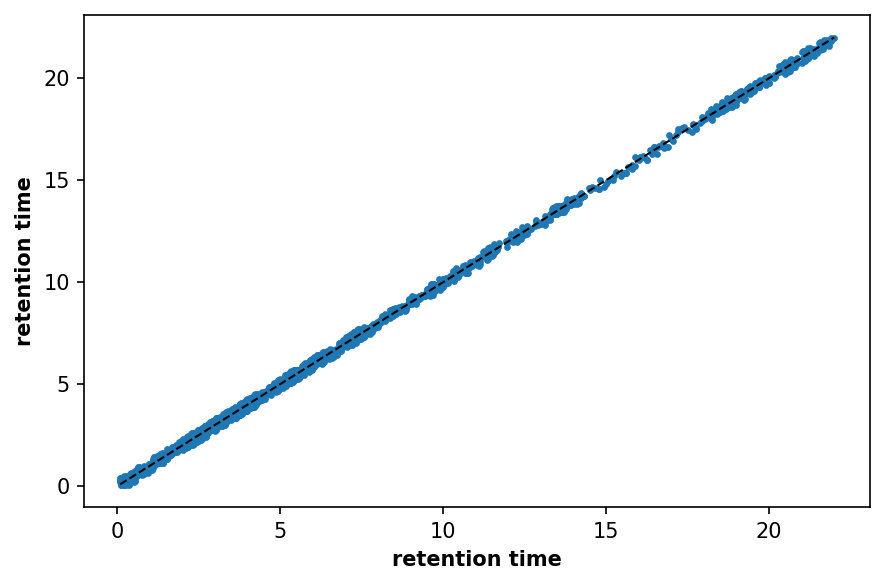

In [17]:
# retention time
x = np.linspace(a_match['retention_time'].min(), a_match['retention_time'].max(), 1000)
y = transform['rt'](x)

plt.figure(dpi=150)
plt.scatter(a_match['retention_time'], b_match['retention_time'], s=5, color='C0')
plt.plot(x, y, linewidth=1, linestyle='--', color='k')
plt.xlabel('retention time', fontweight='bold')
plt.ylabel('retention time', fontweight='bold')
plt.tight_layout()
plt.show()

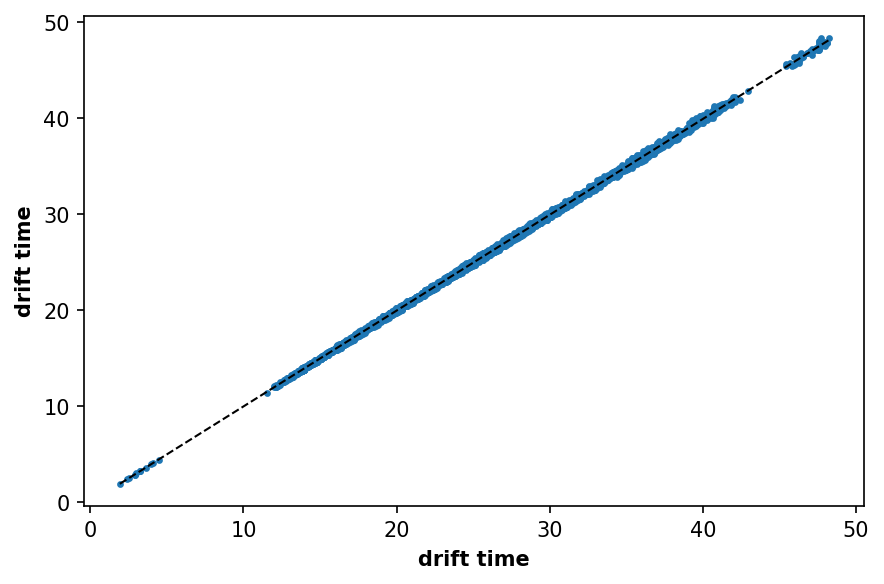

In [18]:
# drift time
x = np.linspace(a_match['drift_time'].min(), a_match['drift_time'].max(), 1000)
y = transform['dt'](x)

plt.figure(dpi=150)
plt.scatter(a_match['drift_time'], b_match['drift_time'], s=5, color='C0')
plt.plot(x, y, linewidth=1, linestyle='--', color='k')
plt.xlabel('drift time', fontweight='bold')
plt.ylabel('drift time', fontweight='bold')
plt.tight_layout()
plt.show()

### Apply regressions
Now that we have our alignment from `a` to `b` calculated (that is, `f(a) = b`), we need to apply the transform to `a` such that it is now aligned to `b`. But remember, these transforms were calculated only on the features that matched. We want to apply the tranform to _all_ features, so we are going to use the thresholded feature list (here, `a_thresh_i`).

In [19]:
# copy so we don't overwrite
ms1_peaks['a_aligned'] = ms1_peaks['a_thresh_i'].copy()

# apply transform
ms1_peaks['a_aligned'].loc[:, 'drift_time'] = transform['dt'](ms1_peaks['a_thresh_i']['drift_time'].values)
ms1_peaks['a_aligned'].loc[:, 'retention_time'] = transform['rt'](ms1_peaks['a_thresh_i']['retention_time'].values)

### Check alignment
Now lets see if we get any more matches after we've aligned!

In [20]:
# partition
partitions = deimos.partition(ms1_peaks['a_aligned'], split_on='mz', size=1000, overlap=0.05)

# match
a_match2, b_match2 = partitions.zipmap(deimos.alignment.match,
                                       ms1_peaks['b_thresh_i'], processes=4,
                                       relative=[True, True, False], tol=[20E-6, 0.015, 0.3])
print('Matched features:\t{}'.format(len(a_match2)))

Matched features:	4520


Well, no change compared to our first attempt. But that doesn't mean we did anything wrong! Likely just means there wasn't much instrument drift between `a` and `b`, so the same features that matched before alignment also matched after alignment.

### Saving alignment results
Let's go ahead and apply our alignment to all of the data in `a`, unthresholded, and then save it in the peaks folder. Note that the MS "level" in the HDF5 store are determined from dictionary keys, hence we pass what we're trying to save as a `dict` with the key "ms1".

In [21]:
# copy so we don't overwrite
ms1_peaks['a_aligned'] = ms1_peaks['a'].copy()

# apply transform
ms1_peaks['a_aligned'].loc[:, 'drift_time'] = transform['dt'](ms1_peaks['a']['drift_time'].values)
ms1_peaks['a_aligned'].loc[:, 'retention_time'] = transform['rt'](ms1_peaks['a']['retention_time'].values)

# save
deimos.save_hdf('peaks/a_POS_40V_aligned.h5', ms1_peaks['a_aligned'], key='ms1')